In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
# from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint

In [30]:
BASE_DIR = r'C:/Users/grish/Downloads/archive/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(BASE_DIR) if '.' not in i]
classes

image_dir = Path(r'C:/Users/grish/Downloads/archive/Fish_Dataset/Fish_Dataset')

# Получение путей к файлам и меток
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
image_paths = []
image_paths_gt = []
image_classes = np.array([[cls]*1000 for cls in classes]).reshape(-1)
for cls in classes:
    gt = cls + ' GT'
    image_paths.extend([os.path.join(BASE_DIR, cls,cls, i) for i in os.listdir(os.path.join(BASE_DIR, cls,cls))])
    image_paths_gt.extend([os.path.join(BASE_DIR, cls,gt, i) for i in os.listdir(os.path.join(BASE_DIR, cls, gt))])

In [5]:
img_shape = (590 , 445, 3)

In [6]:
data = pd.DataFrame({'path':image_paths, 'class':image_classes, })
data.head()

,path,class
0,C:/Users/grish/Downloads/archive/Fish_Dataset/...,Black Sea Sprat
1,C:/Users/grish/Downloads/archive/Fish_Dataset/...,Black Sea Sprat
2,C:/Users/grish/Downloads/archive/Fish_Dataset/...,Black Sea Sprat
3,C:/Users/grish/Downloads/archive/Fish_Dataset/...,Black Sea Sprat
4,C:/Users/grish/Downloads/archive/Fish_Dataset/...,Black Sea Sprat


In [7]:
data_gt = pd.DataFrame({'path':image_paths_gt, 'class':image_classes, })
data_gt.head()

,path,class
0,C:/Users/grish/Downloads/archive/Fish_Dataset/...,Black Sea Sprat
1,C:/Users/grish/Downloads/archive/Fish_Dataset/...,Black Sea Sprat
2,C:/Users/grish/Downloads/archive/Fish_Dataset/...,Black Sea Sprat
3,C:/Users/grish/Downloads/archive/Fish_Dataset/...,Black Sea Sprat
4,C:/Users/grish/Downloads/archive/Fish_Dataset/...,Black Sea Sprat


In [8]:
train_df, test_df = train_test_split(data, train_size=0.9, shuffle=True, random_state=1)

In [9]:
def get_generators(data, is_rgb =True):
    color_mode = 'rgb' if is_rgb else 'grayscale'
    data_full, data_remainder = train_test_split(data, stratify = data['class'], test_size = 0.2)
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, validation_split=0.1)

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255)
    train_generator = train_datagen.flow_from_dataframe(data_full, x_col='path', y_col='class',
         target_size=img_shape[:-1], color_mode=color_mode,
        class_mode='categorical', batch_size=32, shuffle=True,
        subset='training'
        )
    val_generator = train_datagen.flow_from_dataframe(data_full, x_col='path', y_col='class',
         target_size=img_shape[:-1], color_mode=color_mode,
        class_mode='categorical', batch_size=32, shuffle=True,
        subset='validation'
        )
    test_generator = test_datagen.flow_from_dataframe(data_remainder, x_col = 'path', y_col = 'class', target_size = img_shape[:-1], color_mode = color_mode,class_mode = 'categorical')
    return train_generator, val_generator, test_generator

In [10]:
train_gen, val_gen, test_gen = get_generators(data)

Found 6480 validated image filenames belonging to 9 classes.
Found 720 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [11]:
img_shape = (590 , 445, 3)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3), strides = 3, input_shape = img_shape),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3,3),strides=2),
    
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,(3,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation = 'softmax')
])
model.summary()

C:\Users\grish\PycharmProjects\FishClassifier\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 196, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 36, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,689 (1014.41 KB)

 Trainable params: 259,689 (1014.41 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
earlystop = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights=True )
schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.002, decay_steps = 1000, decay_rate = 0.7)
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate =schedule), metrics = ['accuracy'])
history = model.fit(train_gen, validation_data = val_gen,epochs = 100, callbacks = [earlystop])

Epoch 1/100


C:\Users\grish\PycharmProjects\FishClassifier\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


203/203 ━━━━━━━━━━━━━━━━━━━━ 54s 254ms/step - accuracy: 0.3466 - loss: 1.7553 - val_accuracy: 0.7597 - val_loss: 0.7616
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 50s 239ms/step - accuracy: 0.6837 - loss: 0.8613 - val_accuracy: 0.8403 - val_loss: 0.4531
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 50s 238ms/step - accuracy: 0.8013 - loss: 0.5561 - val_accuracy: 0.8486 - val_loss: 0.3942
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 50s 238ms/step - accuracy: 0.8251 - loss: 0.5072 - val_accuracy: 0.8931 - val_loss: 0.2768
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 51s 244ms/step - accuracy: 0.8800 - loss: 0.3279 - val_accuracy: 0.9333 - val_loss: 0.1984
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 51s 243ms/step - accuracy: 0.9171 - loss: 0.2313 - val_accuracy: 0.9486 - val_loss: 0.1584
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 50s 242ms/step - accuracy: 0.9265 - loss: 0.2057 - val_accuracy: 0.9569 - val_loss: 0.1304
Epoch 8/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 49s 235ms/step - accuracy: 0.9324 - loss: 0.190

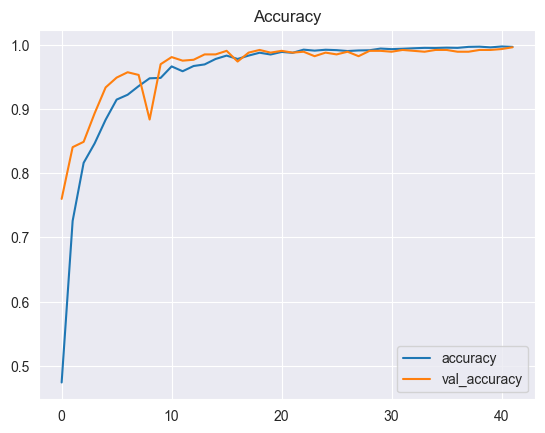

In [14]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

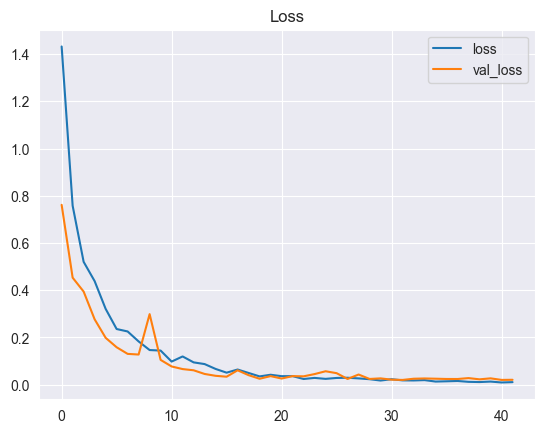

In [15]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [16]:
model.save("my_model_better.keras")

In [17]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

C:\Users\grish\PycharmProjects\FishClassifier\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 0.01976
Test Accuracy: 99.39%
